In [348]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 1
%aimport visualization.vis
%aimport utils.utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import io

from torch_geometric.loader import DataLoader
from argparse import ArgumentParser
from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from predictors.environment import WorldModel
from transforms import TargetBuilder
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)
from av2.map.map_api import ArgoverseStaticMap
from pathlib import Path
from visualization.vis import plot_traj_with_data, plot_traj, vis_reward, generate_video
from utils.utils import get_transform_mat, get_auto_pred, add_new_agent, reward_function

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="/home/guanren/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
environment = {
    "QCNet": WorldModel,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [350]:
dataloader = DataLoader(
    # val_dataset[[val_dataset.raw_file_names.index('0a8dd03b-02cf-4d7b-ae7f-c9e65ad3c900')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a0ef009-9d44-4399-99e6-50004d345f34')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a09b183-3553-4c85-9a12-976409e4aeab')]],
    # val_dataset[[val_dataset.raw_file_names.index('00a9541f-a00c-45c6-9071-dec34f5f818b')]],
    val_dataset[[val_dataset.raw_file_names.index('0aa35936-8a93-4174-8491-ee4b0bece920')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [351]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/dc0c0d10-4fc2-43a5-be66-6475a9ce0b1c/scenario_dc0c0d10-4fc2-43a5-be66-6475a9ce0b1c.parquet


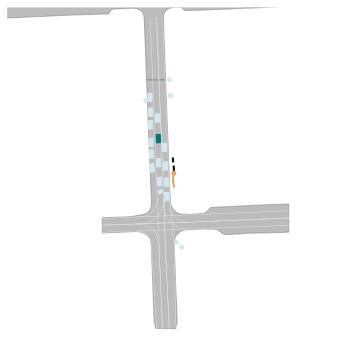

In [352]:

scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)
plot_traj(scenario_static_map,scenario)

In [285]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False

from torch_geometric.data import Batch
from utils import wrap_angle
import torch, math
import copy
import numpy as np

if isinstance(data, Batch):
    data['agent']['av_index'] += data['agent']['ptr'][:-1]

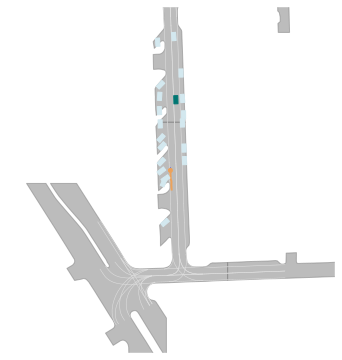

In [287]:
plot_traj_with_data(data,scenario_static_map,1,t=90)
agent_index = torch.nonzero(data['agent']['category']==3,as_tuple=False).item()
# print(data['agent']['position'][agent_index,50:,:2])
# print(data['agent']['heading'][agent_index,50:])

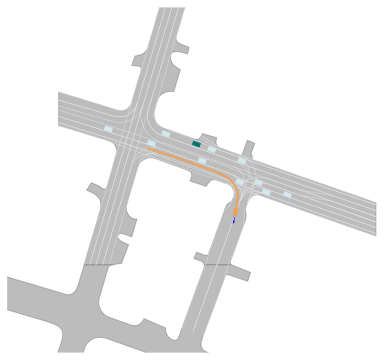

In [244]:

# v0_x = 1*math.cos(1.19)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(data,0.3, v0_x, v0_y, 1.19, 2665, -2410)
# v0_x = 1*math.cos(-1.95)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, -1.95, 2693, -2340)
# v0_x = -1*math.cos(-0.33)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,-0.3, v0_x, v0_y, -0.33, 2725, -2386)

# v0_x = 1*math.cos(1.9338)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(data,0.3, v0_x, v0_y, 1.9338, 5257.3, 325)
# v0_x = 1*math.cos(5.07)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 5.07, 5235, 385)
# v0_x = 1*math.cos(5.07)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 5.07, 5229.7, 411)
# init_origin,init_theta,init_rot_mat=get_transform_mat(new_input_data,model)


v0_x = 1*math.cos(0.1)
v0_y = math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(data,1.0, v0_x, v0_y, 0.1, -8379.8809, -828.5)
v0_x = -1*math.cos(3.15)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.8, v0_x, v0_y, 3.15, -8311, -823)
v0_x = -1*math.cos(1.8)
v0_y = math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.5, v0_x, v0_y, 1.8, -8339, -853)
v0_x = 1*math.cos(4.76)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.5, v0_x, v0_y, 4.76, -8345, -793)

plot_traj_with_data(new_input_data,scenario_static_map, 5, bounds=80,t=90)

In [245]:
vid_path = "test3.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

tensor([[3.8458, 3.8724, 3.7782, 3.8910, 3.8949, 3.9828]], device='cuda:0')
tensor([[7.0473, 7.1353, 7.0325, 7.1442, 7.1102, 7.2555]], device='cuda:0')
tensor([[ 9.9546, 10.0152, 10.0864, 10.1433, 10.0177, 10.1652]],
       device='cuda:0')
tensor([[12.5066, 12.5439, 12.5978, 12.6246, 12.6195, 12.6738]],
       device='cuda:0')
tensor([[14.8532, 15.0112, 14.9918, 15.0047, 15.0281, 15.0326]],
       device='cuda:0')
tensor([[17.2872, 17.4037, 17.3569, 17.5444, 17.4382, 17.4956]],
       device='cuda:0')
tensor([[19.8774, 19.9781, 19.9306, 19.9946, 19.9764, 20.0481]],
       device='cuda:0')
tensor([[22.8384, 22.8870, 22.8497, 22.9413, 22.9201, 22.9779]],
       device='cuda:0')
tensor([[26.2435, 26.2034, 26.1989, 26.2687, 26.2486, 26.3141]],
       device='cuda:0')
tensor([[30.1797, 30.0922, 30.0748, 30.1361, 30.1234, 30.1809]],
       device='cuda:0')
tensor([[34.4574, 34.3407, 34.3192, 34.3684, 34.3691, 34.4336]],
       device='cuda:0')
tensor([[39.1557, 39.0488, 39.0342, 39.0953, 39

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


/tmp/ipykernel_269589/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


IndexError: The shape of the mask [29] at index 0 does not match the shape of the indexed tensor [30, 6, 60, 4] at index 0

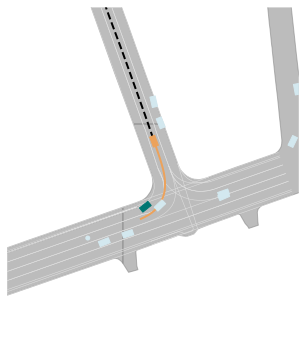

In [ ]:
plot_traj(50.0)
for i in range(6):
    xy = true_traj_refine[[data["agent"]["category"] == 2]][0].cpu().detach()
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])
# for i in range(6):
#     xy = new_position[1][data["agent"]["category"] == 3][0].cpu().detach()
#     plt.plot(xy[i, ..., 0], xy[i, ..., 1])


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

In [17]:

import csv, random

data = []

for i in range(1, 501):
    data.append(random.uniform(-14, -11))

data = [[num] for num in data]

with open('/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3_agent1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)
print('done')

done


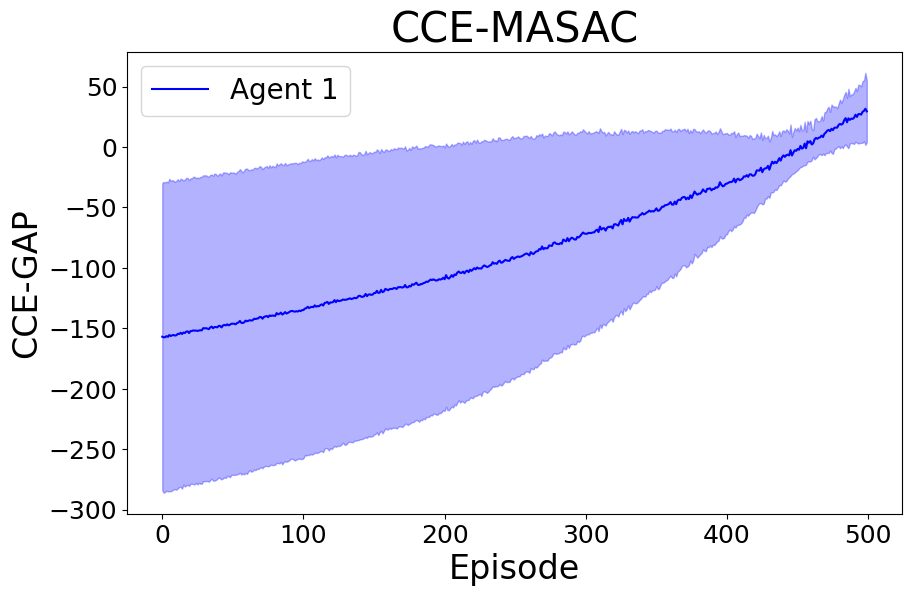

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
for i in range(3*4, 3):
    file_paths = [
      '/home/guanren/Multi-agent-competitive-environment/figures/version_56/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_scenario2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/figures/version_58/CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_scenario2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/figures/version_57/CCE-MASAC_episode500_epoch10_beta1e-2_seed1666_scenario2_CCE-GAP_agent1.csv',

      '/home/guanren/Multi-agent-competitive-environment/figures/version_4/MASAC_episode500_epoch10_seed666_task2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/figures/version_2/MASAC_episode500_epoch10_seed1000_task2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/figures/version_5/MASAC_episode500_epoch10_seed1234_task2_CCE-GAP_agent1.csv',
    ]
    expert_data = [
      '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed666_scenario2/expert_CCE-MASAC_episode500_epoch10_beta1e-2_seed666_scenario2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed1000_scenario2/expert_CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_scenario2_CCE-GAP_agent1.csv',
      '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/CCE-GAP/CCE-MASAC/expert_CCE-MASAC_seed1666_scenario2/expert_CCE-MASAC_episode500_epoch10_beta1e-2_seed1666_scenario2_CCE-GAP_agent1.csv',

      '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/CCE-GAP/MASAC/expert_MASAC_seed1666_scenario2/expert_MASAC_episode500_epoch10_seed1666_scenario2_CCE-GAP_agent1.csv'
    ]
    colors = ['blue', 'green', 'red','purple']

    data1 = pd.read_csv(file_paths[i], header=None)
    data2 = pd.read_csv(file_paths[i+1], header=None)
    data3 = pd.read_csv(file_paths[i+2], header=None)

    expert_data1 = pd.read_csv(expert_data[i],header=None, usecols=[0]).transpose()
    expert_data2 = pd.read_csv(expert_data[i+1],header=None, usecols=[0]).transpose()
    expert_data3 = pd.read_csv(expert_data[i+2],header=None, usecols=[0]).transpose()

    data1 = expert_data1 - data1
    data2 = expert_data2 - data2
    data3 = expert_data3 - data3
    df_combined = pd.concat([data1, data2, data3], axis=0)

    window_size = 100
    df_combined.rolling(window=window_size, min_periods=1).mean()

    mean_values = df_combined.mean(axis=0)
    std_values = df_combined.std(axis=0)

    plt.plot(mean_values, label=f'Agent 1', color=colors[i])
    plt.fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

    plt.title('CCE-MASAC', fontsize=30)
    plt.xlabel('Episode', fontsize=24)
    plt.ylabel('CCE-GAP', fontsize=24)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    # plt.savefig('cce-gap-4.png')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


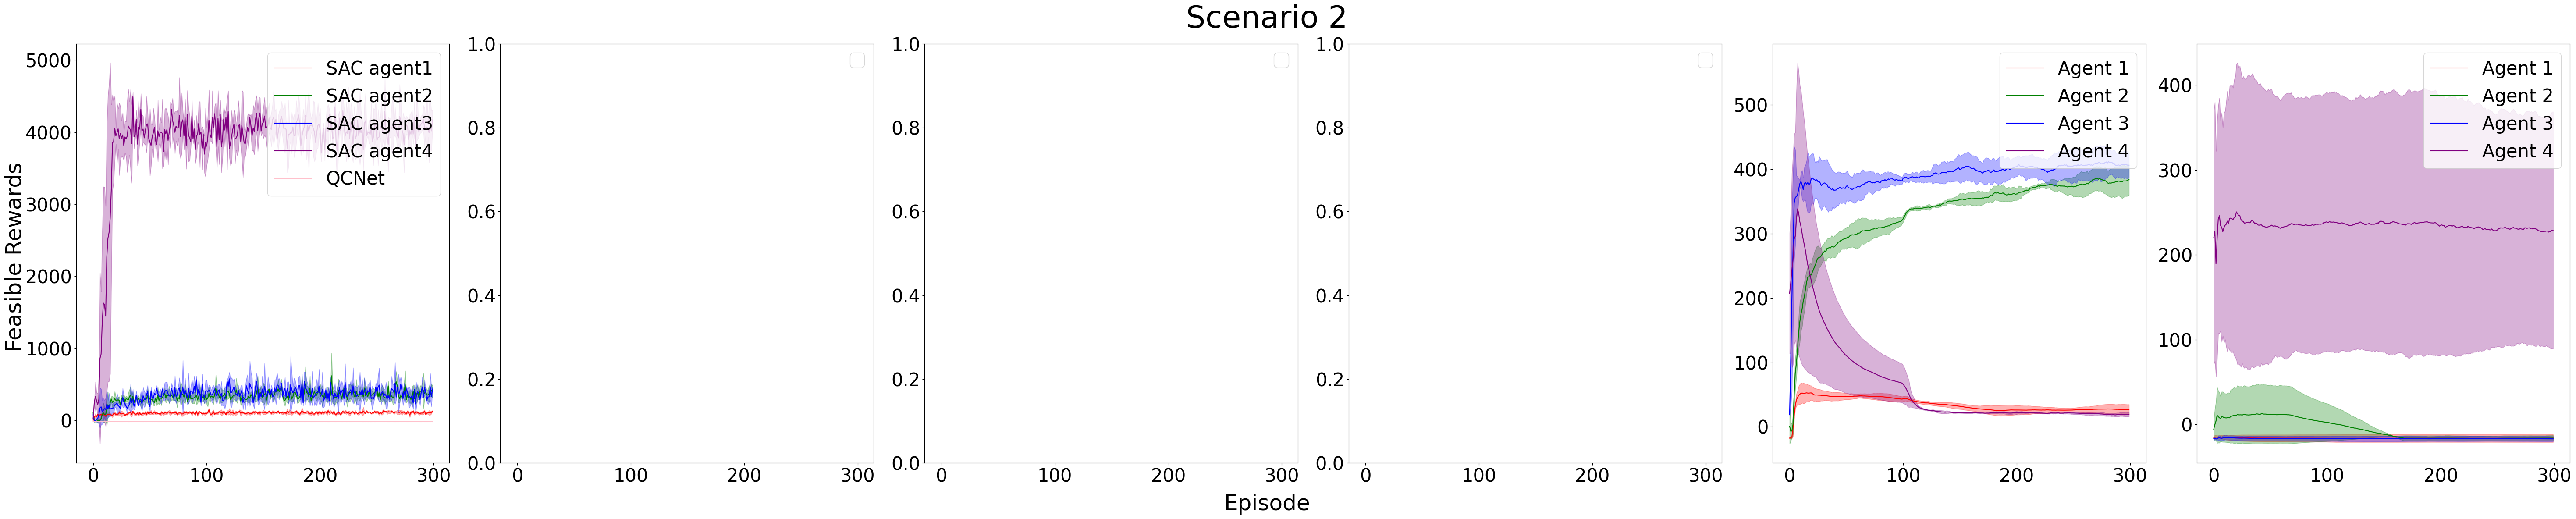

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 6, figsize=(60, 12), sharex=True, sharey=False)

datas = []
labels = ['SAC agent1', 'SAC agent2','SAC agent3','SAC agent4','QCNet']
colors = ['red', 'green', 'blue','purple','pink']
file_paths1 = [
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_32/SAC_episode500_epoch10_seed666_scenario1_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_33/SAC_episode500_epoch10_seed1234_scenario1_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_34/SAC_episode500_epoch10_seed1000_scenario1_agent3_agent-number1.csv',
    
    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_43/SAC_episode500_epoch10_seed1000_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_44/SAC_episode500_epoch10_seed666_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_45/SAC_episode500_epoch10_seed1234_scenario3_agent3_agent-number1.csv',
]
data1 = pd.read_csv(file_paths1[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths1[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths1[2], header=None, usecols=[0]).transpose()
df_combined1 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined1)

file_paths2 = [
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_26/SAC_episode500_epoch10_seed1000_scenario1_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_27/SAC_episode500_epoch10_seed666_scenario1_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_28/SAC_episode500_epoch10_seed1234_scenario1_agent-2_agent-number1.csv',

    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-3_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_59/SAC_episode500_epoch10_seed1000_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_60/SAC_episode500_epoch10_seed666_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_61/SAC_episode500_epoch10_seed1666_scenario3_agent-4_agent-number1.csv',
]
data1 = pd.read_csv(file_paths2[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths2[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths2[2], header=None, usecols=[0]).transpose()
df_combined2 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined2)

file_paths3 =[
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_25/SAC_episode500_epoch10_seed666_scenario1_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_23/SAC_episode500_epoch10_seed1000_scenario1_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_38/SAC_episode500_epoch10_seed1234_scenario1_agent-3_agent-number1.csv',

    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-2_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_64/SAC_episode500_epoch10_seed1666_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_62/SAC_episode500_epoch10_seed1000_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_63/SAC_episode500_epoch10_seed666_scenario3_agent-3_agent-number1.csv',
]
data1 = pd.read_csv(file_paths3[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths3[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths3[2], header=None, usecols=[0]).transpose()
df_combined3 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined3)

file_paths4 =[
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_35/SAC_episode500_epoch10_seed666_scenario1_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_36/SAC_episode500_epoch10_seed1000_scenario1_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_37/SAC_episode500_epoch10_seed1234_scenario1_agent-1_agent-number1.csv',
    
    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-1_agent-number1.csv'

    #scenario3
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_65/SAC_episode500_epoch10_seed1000_scenario3_agent-2_agent-number1.csv',
    ## '/home/guanren/Multi-agent-competitive-environment/figures/version_66/SAC_episode500_epoch10_seed1666_scenario3_agent-2_agent-number1.csv',
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_67/SAC_episode500_epoch10_seed666_scenario3_agent-2_agent-number1.csv',
]
data1 = pd.read_csv(file_paths4[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths4[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths4[2], header=None, usecols=[0]).transpose()
df_combined4 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined4)
file_paths = [
        #scenario1
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1234_scenario1/QCNet_seed1234_scenario1.csv'

        #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2.csv', 
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2.csv',
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1234_scenario2/QCNet_seed1234_scenario2.csv'

        #scenario3
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv'
]

data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
df_combined = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined)

for i in range(5):
    window_size = 100
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)[:300]
    std_values = datas[i].std(axis=0)[:300]
    axs[0].plot(mean_values, label=labels[i], color=colors[i])
    axs[0].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

# datas = []
# labels = ['SAC', 'QCNet']
# colors = ['orange','pink']
# file_paths5 =[
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_68/SAC_episode500_epoch10_seed666_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_69/SAC_episode500_epoch10_seed1666_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_70/SAC_episode500_epoch10_seed1000_scenario3_agent-1_agent-number1.csv',
# ]
# data1 = pd.read_csv(file_paths5[0], header=None, usecols=[0]).transpose()
# data2 = pd.read_csv(file_paths5[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths5[2], header=None, usecols=[0]).transpose()
# df_combined5 = pd.concat([data1, data2, data3], axis=0)
# datas.append(df_combined5)

# file_paths = ['/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
#                '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
#                '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv']

# data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
# data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
# df_combined = pd.concat([data1, data2, data3], axis=0)
# datas.append(df_combined)

# for i in range(2):
#     window_size = 100
#     datas[i].rolling(window=window_size, min_periods=1).mean()

#     mean_values = datas[i].mean(axis=0)
#     std_values = datas[i].std(axis=0)
#     axs[4].plot(mean_values, label=labels[i], color=colors[i])
#     axs[4].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)
file_paths= [
        # scenario1
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_10/MASAC_episode500_epoch10_seed1000_scenario1_agent-number4.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_11/MASAC_episode500_epoch10_seed666_scenario1_agent-number4.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_12/MASAC_episode500_epoch10_seed1234_scenario1_agent-number4.csv',

        # scenario3
#       #'/home/guanren/Multi-agent-competitive-environment/figures/version_20/MASAC_episode500_epoch10_seed666_scenario3_agent-number5.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_21/MASAC_episode500_epoch10_seed1234_scenario3_agent-number5.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_18/MASAC_episode500_epoch10_seed1000_scenario3_agent-number5.csv',
    
        # scenario2
        '/home/guanren/Multi-agent-competitive-environment/figures/version_2/MASAC_episode500_epoch10_seed1000_task2_agent-number4.csv',
        '/home/guanren/Multi-agent-competitive-environment/figures/version_5/MASAC_episode500_epoch10_seed1234_task2_agent-number4.csv',
        '/home/guanren/Multi-agent-competitive-environment/figures/version_4/MASAC_episode500_epoch10_seed666_task2_agent-number4.csv'
]

agent_data = {}

for file_path in file_paths:
    data = pd.read_csv(file_path)
    for (i, column) in enumerate(data.columns):
        if i not in agent_data:
            agent_data[i] = data[column]
        else:
            agent_data[i] = pd.concat([agent_data[i], data[column]], axis=1)

window_size = 100
for agent_id in agent_data:
    agent_data[agent_id] = agent_data[agent_id].rolling(window=window_size, min_periods=1).mean()

for agent_id, data in agent_data.items():
    mean_values = data.mean(axis=1)[:300]
    std_values = data.std(axis=1)[:300]

    axs[-2].plot(mean_values, label=f'Agent {agent_id+1}', color=colors[agent_id])
    axs[-2].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[agent_id], alpha=0.3)

file_paths= [
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_58/CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_scenario2_agent-number4.csv',
             '/home/guanren/Multi-agent-competitive-environment/figures/version_57/CCE-MASAC_episode500_epoch10_beta1e-2_seed1666_scenario2_agent-number4.csv',
             '/home/guanren/Multi-agent-competitive-environment/figures/version_56/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_scenario2_agent-number4.csv']
# file_paths = [
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_53/CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_scenario1_agent-number4.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_54/CCE-MASAC_episode500_epoch10_beta1e-2_seed1666_scenario1_agent-number4.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_55/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_scenario1_agent-number4.csv',
# ]
# file_paths = [
#       #'/home/guanren/Multi-agent-competitive-environment/figures/version_50/CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_scenario3_agent-number5.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_51/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_scenario3_agent-number5.csv',
#       '/home/guanren/Multi-agent-competitive-environment/figures/version_52/CCE-MASAC_episode500_epoch10_beta1e-2_seed1666_scenario3_agent-number5.csv',
# ]
colors = ['red', 'green', 'blue','purple','orange']

agent_data = {}

for file_path in file_paths:
    data = pd.read_csv(file_path)
    for (i, column) in enumerate(data.columns):
        if i not in agent_data:
            agent_data[i] = data[column]
        else:
            agent_data[i] = pd.concat([agent_data[i], data[column]], axis=1)

window_size = 100
for agent_id in agent_data:
    agent_data[agent_id] = agent_data[agent_id].rolling(window=window_size, min_periods=1).mean()

for agent_id, data in agent_data.items():
    mean_values = data.mean(axis=1)[:300]
    std_values = data.std(axis=1)[:300]

    axs[-1].plot(mean_values, label=f'Agent {agent_id+1}', color=colors[agent_id])
    axs[-1].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[agent_id], alpha=0.3)

for ax in axs:
    ax.legend(fontsize=30, loc='upper right')

for ax in axs:
    ax.tick_params(axis='both', labelsize=30)

fig.suptitle('Scenario 2', fontsize=50)
fig.supxlabel('Episode', fontsize=36)
fig.supylabel('Feasible Rewards', fontsize=36)
plt.tight_layout(rect=[0.015, 0, 1, 1])
# plt.savefig("/home/guanren/Multi-agent-competitive-environment/results/scenario2_cce-masac.png")
plt.show()

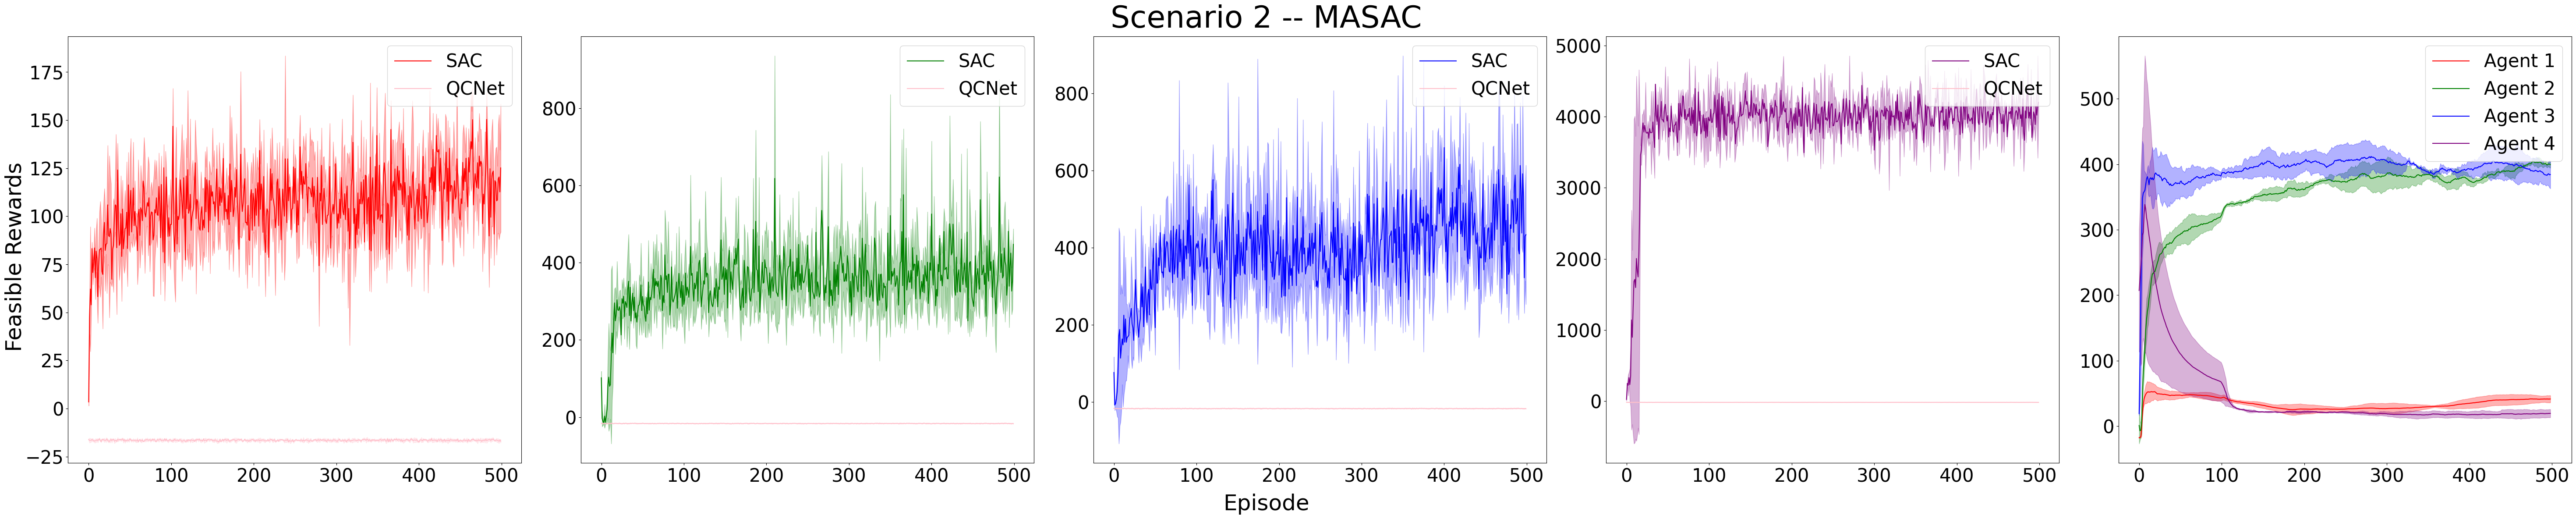

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 5, figsize=(60, 12), sharex=True, sharey=False)

datas = []
labels = ['SAC', 'QCNet']
colors = ['red','pink']
file_paths1 = [
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_32/SAC_episode500_epoch10_seed666_scenario1_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_33/SAC_episode500_epoch10_seed1234_scenario1_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_34/SAC_episode500_epoch10_seed1000_scenario1_agent3_agent-number1.csv',
    
    #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_43/SAC_episode500_epoch10_seed1000_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_44/SAC_episode500_epoch10_seed666_scenario3_agent3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_45/SAC_episode500_epoch10_seed1234_scenario3_agent3_agent-number1.csv',
]
data1 = pd.read_csv(file_paths1[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths1[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths1[2], header=None, usecols=[0]).transpose()
df_combined1 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined1)
file_paths = [
        #scenario1
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1234_scenario1/QCNet_seed1234_scenario1.csv'

        #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2.csv', 
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2.csv',
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1234_scenario2/QCNet_seed1234_scenario2.csv'

        #scenario3
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv'
]
data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
df_combined = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined)

for i in range(2):
    window_size = 100
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)
    axs[0].plot(mean_values, label=labels[i], color=colors[i])
    axs[0].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

datas = []
labels = ['SAC', 'QCNet']
colors = ['green','pink']
file_paths2 = [
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_26/SAC_episode500_epoch10_seed1000_scenario1_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_27/SAC_episode500_epoch10_seed666_scenario1_agent-2_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_28/SAC_episode500_epoch10_seed1234_scenario1_agent-2_agent-number1.csv',

    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-3_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-3_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_59/SAC_episode500_epoch10_seed1000_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_60/SAC_episode500_epoch10_seed666_scenario3_agent-4_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_61/SAC_episode500_epoch10_seed1666_scenario3_agent-4_agent-number1.csv',
]
data1 = pd.read_csv(file_paths2[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths2[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths2[2], header=None, usecols=[0]).transpose()
df_combined2 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined2)
file_paths = [
        #scenario1
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1234_scenario1/QCNet_seed1234_scenario1.csv'

        #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2.csv', 
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2.csv',
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1234_scenario2/QCNet_seed1234_scenario2.csv'

        #scenario3
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv'
]
data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
df_combined = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined)

for i in range(2):
    window_size = 100
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)
    axs[1].plot(mean_values, label=labels[i], color=colors[i])
    axs[1].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

datas = []
labels = ['SAC', 'QCNet']
colors = ['blue','pink']


file_paths3 =[
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_25/SAC_episode500_epoch10_seed666_scenario1_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_23/SAC_episode500_epoch10_seed1000_scenario1_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_38/SAC_episode500_epoch10_seed1234_scenario1_agent-3_agent-number1.csv',

    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-2_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-2_agent-number1.csv'

    #scenario3
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_64/SAC_episode500_epoch10_seed1666_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_62/SAC_episode500_epoch10_seed1000_scenario3_agent-3_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_63/SAC_episode500_epoch10_seed666_scenario3_agent-3_agent-number1.csv',
]
data1 = pd.read_csv(file_paths3[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths3[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths3[2], header=None, usecols=[0]).transpose()
df_combined3 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined3)
file_paths = [
        #scenario1
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1234_scenario1/QCNet_seed1234_scenario1.csv'

        #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2.csv', 
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2.csv',
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1234_scenario2/QCNet_seed1234_scenario2.csv'

        #scenario3
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv'
]
data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
df_combined = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined)

for i in range(2):
    window_size = 100
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)
    axs[2].plot(mean_values, label=labels[i], color=colors[i])
    axs[2].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

datas = []
labels = ['SAC', 'QCNet']
colors = ['purple','pink']

file_paths4 =[
    #scenario1
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_35/SAC_episode500_epoch10_seed666_scenario1_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_36/SAC_episode500_epoch10_seed1000_scenario1_agent-1_agent-number1.csv',
    # '/home/guanren/Multi-agent-competitive-environment/figures/version_37/SAC_episode500_epoch10_seed1234_scenario1_agent-1_agent-number1.csv',
    
    #scenario2
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed666_scenario2/SAC_episode500_epoch10_seed666_scenario2_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1000_scenario2/SAC_episode500_epoch10_seed1000_scenario2_agent-1_agent-number1.csv',
    '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/SAC/SAC_seed1234_scenario2/SAC_episode500_epoch10_seed1234_scenario2_agent-1_agent-number1.csv'

    #scenario3
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_65/SAC_episode500_epoch10_seed1000_scenario3_agent-2_agent-number1.csv',
    ## '/home/guanren/Multi-agent-competitive-environment/figures/version_66/SAC_episode500_epoch10_seed1666_scenario3_agent-2_agent-number1.csv',
    #'/home/guanren/Multi-agent-competitive-environment/figures/version_67/SAC_episode500_epoch10_seed666_scenario3_agent-2_agent-number1.csv',
]
data1 = pd.read_csv(file_paths4[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths4[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths4[2], header=None, usecols=[0]).transpose()
df_combined4 = pd.concat([data1, data2], axis=0)
datas.append(df_combined4)
file_paths = [
        #scenario1
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed666_scenario1/QCNet_seed666_scenario1.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1000_scenario1/QCNet_seed1000_scenario1.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario1/reward/QCNet/QCNet_seed1234_scenario1/QCNet_seed1234_scenario1.csv'

        #scenario2
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed666_scenario2/QCNet_seed666_scenario2.csv', 
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1000_scenario2/QCNet_seed1000_scenario2.csv',
        '/home/guanren/Multi-agent-competitive-environment/performance/scenario2/reward/QCNet/QCNet_seed1234_scenario2/QCNet_seed1234_scenario2.csv'

        #scenario3
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
        # '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv'
]

data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
df_combined = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined)

for i in range(2):
    window_size = 100
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)
    axs[3].plot(mean_values, label=labels[i], color=colors[i])
    axs[3].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

# datas = []
# labels = ['SAC', 'QCNet']
# colors = ['orange','pink']
# file_paths5 =[
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_68/SAC_episode500_epoch10_seed666_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_69/SAC_episode500_epoch10_seed1666_scenario3_agent-1_agent-number1.csv',
#     '/home/guanren/Multi-agent-competitive-environment/figures/version_70/SAC_episode500_epoch10_seed1000_scenario3_agent-1_agent-number1.csv',
# ]
# data1 = pd.read_csv(file_paths5[0], header=None, usecols=[0]).transpose()
# data2 = pd.read_csv(file_paths5[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths5[2], header=None, usecols=[0]).transpose()
# df_combined5 = pd.concat([data1, data2, data3], axis=0)
# datas.append(df_combined5)

# file_paths = ['/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed666_scenario3/QCNet_seed666_scenario3.csv', 
#                '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1000_scenario3/QCNet_seed1000_scenario3.csv',
#                '/home/guanren/Multi-agent-competitive-environment/performance/scenario3/reward/QCNet/QCNet_seed1234_scenario3/QCNet_seed1234_scenario3.csv']

# data1 = pd.read_csv(file_paths[0], header=None, usecols=[0]).transpose()
# data2 = pd.read_csv(file_paths[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths[2], header=None, usecols=[0]).transpose()
# df_combined = pd.concat([data1, data2, data3], axis=0)
# datas.append(df_combined)

# for i in range(2):
#     window_size = 100
#     datas[i].rolling(window=window_size, min_periods=1).mean()

#     mean_values = datas[i].mean(axis=0)
#     std_values = datas[i].std(axis=0)
#     axs[4].plot(mean_values, label=labels[i], color=colors[i])
#     axs[4].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[i], alpha=0.3)

file_paths= [
            '/home/guanren/Multi-agent-competitive-environment/figures/version_2/MASAC_episode500_epoch10_seed1000_task2_agent-number4.csv',
            '/home/guanren/Multi-agent-competitive-environment/figures/version_5/MASAC_episode500_epoch10_seed1234_task2_agent-number4.csv',
            '/home/guanren/Multi-agent-competitive-environment/figures/version_4/MASAC_episode500_epoch10_seed666_task2_agent-number4.csv']

colors = ['red', 'green', 'blue','purple','orange']

agent_data = {}

for file_path in file_paths:
    data = pd.read_csv(file_path)
    for (i, column) in enumerate(data.columns):
        if i not in agent_data:
            agent_data[i] = data[column]
        else:
            agent_data[i] = pd.concat([agent_data[i], data[column]], axis=1)

window_size = 100
for agent_id in agent_data:
    agent_data[agent_id] = agent_data[agent_id].rolling(window=window_size, min_periods=1).mean()

for agent_id, data in agent_data.items():
    mean_values = data.mean(axis=1)
    std_values = data.std(axis=1)

    axs[-1].plot(mean_values, label=f'Agent {agent_id+1}', color=colors[agent_id])
    axs[-1].fill_between(range(len(mean_values)), mean_values+std_values*0.95, mean_values-std_values*0.95, color=colors[agent_id], alpha=0.3)

for ax in axs:
    ax.legend(fontsize=30, loc='upper right')

for ax in axs:
    ax.tick_params(axis='both', labelsize=30)

fig.suptitle('Scenario 2 -- MASAC', fontsize=50)
fig.supxlabel('Episode', fontsize=36)
fig.supylabel('Feasible Rewards', fontsize=36)
plt.tight_layout(rect=[0.015, 0, 1, 1])
plt.savefig("/home/guanren/Multi-agent-competitive-environment/results/scenario2_masac.png")
plt.show()